In [1]:
%matplotlib inline

In [2]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
 

In [3]:

"""
Author:
    Jack Cui
Blog:
    http://blog.csdn.net/c406495762
Zhihu:
    https://www.zhihu.com/people/Jack--Cui/
Modify:
    2017-10-10
"""
 
def loadDataSet(fileName):
    numFeat = len((open(fileName).readline().split('\t')))
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
 
    return dataMat, labelMat
 
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    """
    单层决策树分类函数
    Parameters:
        dataMatrix - 数据矩阵
        dimen - 第dimen列，也就是第几个特征
        threshVal - 阈值
        threshIneq - 标志
    Returns:
        retArray - 分类结果
    """
    retArray = np.ones((np.shape(dataMatrix)[0],1))                #初始化retArray为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0         #如果小于阈值,则赋值为-1
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0         #如果大于阈值,则赋值为-1
    return retArray
 
 
def buildStump(dataArr,classLabels,D):
    """
    找到数据集上最佳的单层决策树
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        D - 样本权重
    Returns:
        bestStump - 最佳单层决策树信息
        minError - 最小误差
        bestClasEst - 最佳的分类结果
    """
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps = 10.0; bestStump = {}; bestClasEst = np.mat(np.zeros((m,1)))
    minError = float('inf')                                                        #最小误差初始化为正无穷大
    for i in range(n):                                                            #遍历所有特征
        rangeMin = dataMatrix[:,i].min(); rangeMax = dataMatrix[:,i].max()        #找到特征中最小的值和最大值
        stepSize = (rangeMax - rangeMin) / numSteps                                #计算步长
        for j in range(-1, int(numSteps) + 1):                                     
            for inequal in ['lt', 'gt']:                                          #大于和小于的情况，均遍历。lt:less than，gt:greater than
                threshVal = (rangeMin + float(j) * stepSize)                     #计算阈值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)#计算分类结果
                errArr = np.mat(np.ones((m,1)))                                 #初始化误差矩阵
                errArr[predictedVals == labelMat] = 0                             #分类正确的,赋值为0
                weightedError = D.T * errArr                                      #计算误差
                # print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:                                     #找到误差最小的分类方式
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst
 
def adaBoostTrainDS(dataArr, classLabels, numIt = 40):
    """
    使用AdaBoost算法训练分类器
    Parameters:
        dataArr - 数据矩阵
        classLabels - 数据标签
        numIt - 最大迭代次数
    Returns:
        weakClassArr - 训练好的分类器
        aggClassEst - 类别估计累计值
    """
    weakClassArr = []
    m = np.shape(dataArr)[0]
    D = np.mat(np.ones((m, 1)) / m)                                            #初始化权重
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)     #构建单层决策树
        # print("D:",D.T)
        alpha = float(0.5 * np.log((1.0 - error) / max(error, 1e-16)))         #计算弱学习算法权重alpha,使error不等于0,因为分母不能为0
        bestStump['alpha'] = alpha                                          #存储弱学习算法权重
        weakClassArr.append(bestStump)                                      #存储单层决策树
        # print("classEst: ", classEst.T)
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)     #计算e的指数项
        D = np.multiply(D, np.exp(expon))                                     
        D = D / D.sum()                                                        #根据样本权重公式，更新样本权重
        #计算AdaBoost误差，当误差为0的时候，退出循环
        aggClassEst += alpha * classEst                                      #计算类别估计累计值                               
        # print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m,1)))     #计算误差
        errorRate = aggErrors.sum() / m
        # print("total error: ", errorRate)
        if errorRate == 0.0: break                                             #误差为0，退出循环
    return weakClassArr, aggClassEst
 
 
def plotROC(predStrengths, classLabels):
    """
    绘制ROC
    Parameters:
        predStrengths - 分类器的预测强度
        classLabels - 类别
    Returns:
        无
    """
    font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc", size=14)
    cur = (1.0, 1.0)                                                         #绘制光标的位置
    ySum = 0.0                                                                 #用于计算AUC
    numPosClas = np.sum(np.array(classLabels) == 1.0)                        #统计正类的数量
    yStep = 1 / float(numPosClas)                                             #y轴步长   
    xStep = 1 / float(len(classLabels) - numPosClas)                         #x轴步长
 
    sortedIndicies = predStrengths.argsort()                                 #预测强度排序
 
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep
        else:
            delX = xStep; delY = 0
            ySum += cur[1]                                                     #高度累加
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')     #绘制ROC
        cur = (cur[0] - delX, cur[1] - delY)                                 #更新绘制光标的位置
    ax.plot([0,1], [0,1], 'b--')
    plt.title('AdaBoost马疝病检测系统的ROC曲线', FontProperties = font)
    plt.xlabel('假阳率', FontProperties = font)
    plt.ylabel('真阳率', FontProperties = font)
    ax.axis([0, 1, 0, 1])
    print('AUC面积为:', ySum * xStep)                                         #计算AUC
    plt.show()
 
 

AUC面积为: 0.8582969635063604


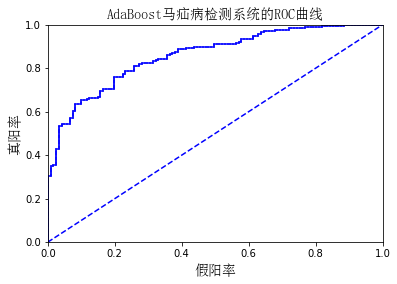

In [4]:
dataArr, LabelArr = loadDataSet('horseColicTraining2.txt')
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, LabelArr, 10)
plotROC(aggClassEst.T, LabelArr)

先解释ROC，图中的横坐标是伪正例的比例（假阳率=FP/（FP+TN）），而纵坐标是真正例的比例（真阳率=TP/（TP+FN））。ROC曲线给出的是当阈值变化时假阳率和真阳率的变化情况。左下角的点所对应的将所有样例判为反例的情况，而右上角的点对应的则是将所有样例判为正例的情况。虚线给出的是随机猜测的结果曲线。

ROC曲线不但可以用于比较分类器，还可以基于成本效益（cost-versus-benefit）分析来做出决策。由于在不同的阈值下，不用的分类器的表现情况是可能各不相同，因此以某种方式将它们组合起来或许更有意义。如果只是简单地观察分类器的错误率，那么我们就难以得到这种更深入的洞察效果了。

在理想的情况下，最佳的分类器应该尽可能地处于左上角，这就意味着分类器在假阳率很低的同时获得了很高的真阳率。例如在垃圾邮件的过滤中，就相当于过滤了所有的垃圾邮件，但没有将任何合法邮件误识别为垃圾邮件而放入垃圾邮件额文件夹中。

对不同的ROC曲线进行比较的一个指标是曲线下的面积（Area Unser the Curve，AUC）。AUC给出的是分类器的平均性能值，当然它并不能完全代替对整条曲线的观察。一个完美分类器的ACU为1.0，而随机猜测的AUC则为0.5。

上面的ROC曲线绘制结果是在10个弱分类器下，AdaBoost算法性能的结果。我们将迭代次数改为50，也就是训练50个弱分类器，看下ROC曲线和AUC的变化：

AUC面积为: 0.8953941870182941


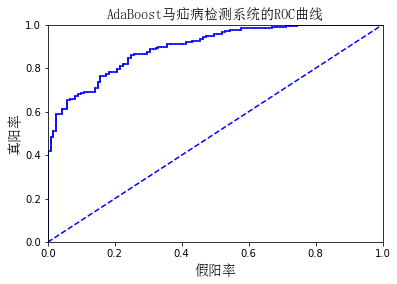

In [6]:
dataArr, LabelArr = loadDataSet('horseColicTraining2.txt')
weakClassArr, aggClassEst = adaBoostTrainDS(dataArr, LabelArr, 50)
plotROC(aggClassEst.T, LabelArr)

ROC曲线往左上角更靠拢了，并且AUC值增加了。也就表明，分类器效果更佳。